In [1]:
# Exploratory Data Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [3]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# and reset all the datatypes to the expected types.
df.race = df.race.astype('category')
df.gender = df.gender.astype('category')
df.facility = df.facility.astype('category')
df.detainer = df.detainer.astype('category')
#df.offense_class = df.offense_class.astype('category')
df.days = pd.to_timedelta(df.days)



# Check that everything worked.  In this EDA, there should be 0 null values.
# df.info()

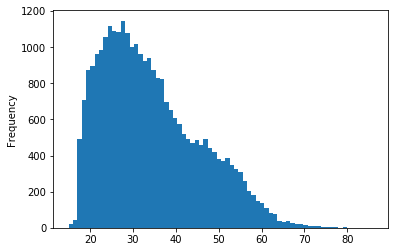

32.0

In [4]:
df.age.plot(kind='hist', bins=70)
plt.show()
df.age.median()

In [5]:
felony_df = df.loc[df['offense_class'].str.endswith('F')]

In [6]:
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

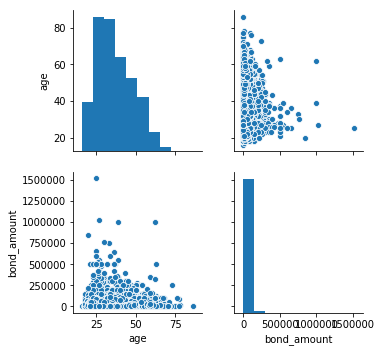

In [7]:
sns.pairplot(misdemeanor_df, vars=['age', 'bond_amount'])

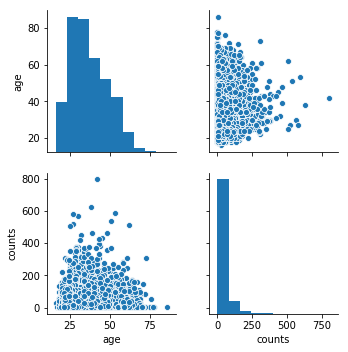

In [8]:
sns.pairplot(misdemeanor_df, vars=['age', 'counts'])

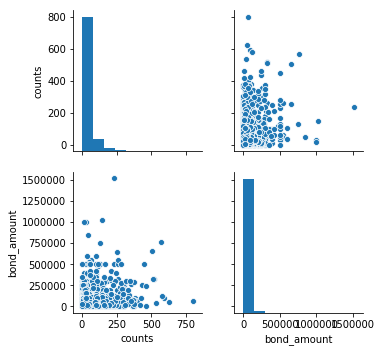

In [9]:
sns.pairplot(misdemeanor_df, vars=['counts', 'bond_amount'])

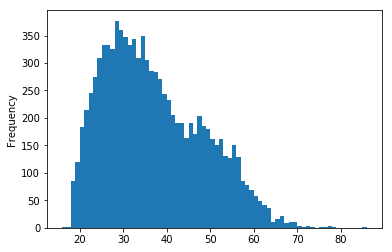

In [10]:
misdemeanor_df['age'].plot.hist(bins=70)

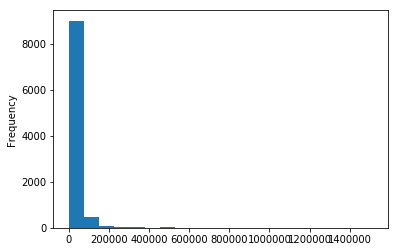

In [11]:
misdemeanor_df['bond_amount'].plot.hist(bins=20)

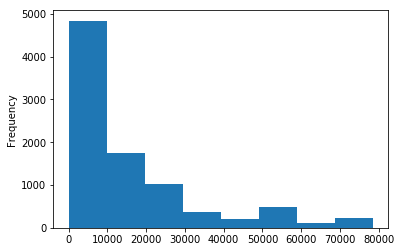

In [12]:
misdemeanor_df['bond_amount'].loc[misdemeanor_df.bond_amount < 80000].plot.hist(bins=8)

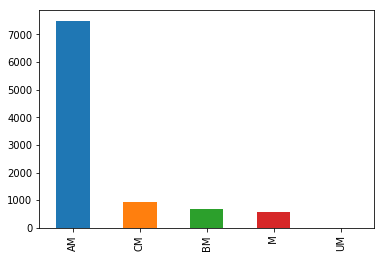

In [13]:
misdemeanor_df['offense_class'].value_counts().plot(kind='bar')

In [14]:
misdemeanor_df.loc[misdemeanor_df.offense_class == 'UM']

,download_date,identifier,latest_admission_date,race,gender,age,bond_amount,offense,facility,detainer,offense_class,days,counts
19035,2016-08-04,ZZSELRRR,2016-08-03,WHITE,M,44,2000,NOTICES IN SALES AGRREMENT UM,BRIDGEPORT CC,NONE,UM,1 days,1


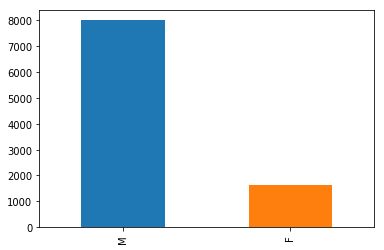

In [15]:
misdemeanor_df['gender'].value_counts().plot(kind='bar')

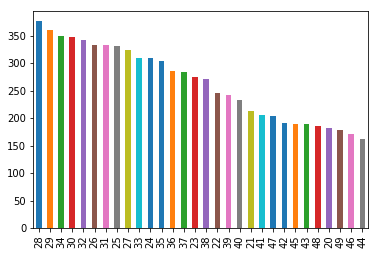

In [16]:
misdemeanor_df['age'].value_counts()[:30].plot(kind='bar')

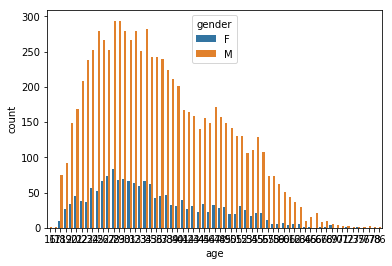

In [17]:
sns.countplot(x='age', hue='gender', data=misdemeanor_df)

In [18]:
#sns.countplot(x='bond_amount', hue='age', data=misdemeanor_df)

In [19]:
#sns.lmplot(data=misdemeanor_df, x='bond_amount', y='offense_class')

In [20]:
#sns.lmplot(x='bond_amount', y='offense_class', data=misdemeanor_df)

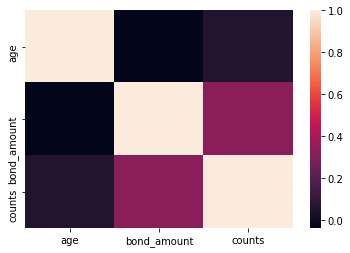

In [21]:
corr = misdemeanor_df.corr()
sns.heatmap(corr)

C:\Users\Misty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


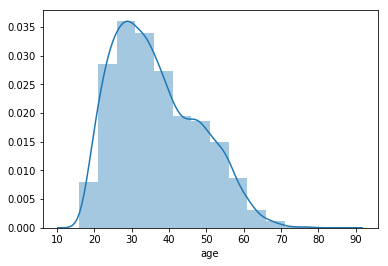

In [22]:
sns.distplot(misdemeanor_df.age, bins=14)

C:\Users\Misty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


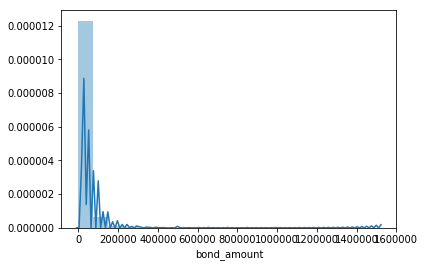

In [23]:
sns.distplot(misdemeanor_df.bond_amount, bins=20)

C:\Users\Misty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


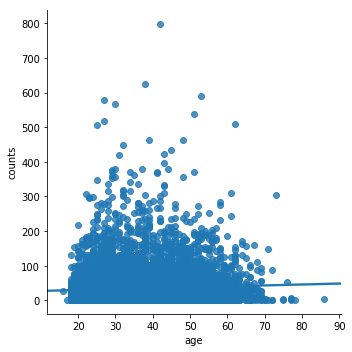

In [24]:
sns.lmplot(data=misdemeanor_df, x='age', y='counts')

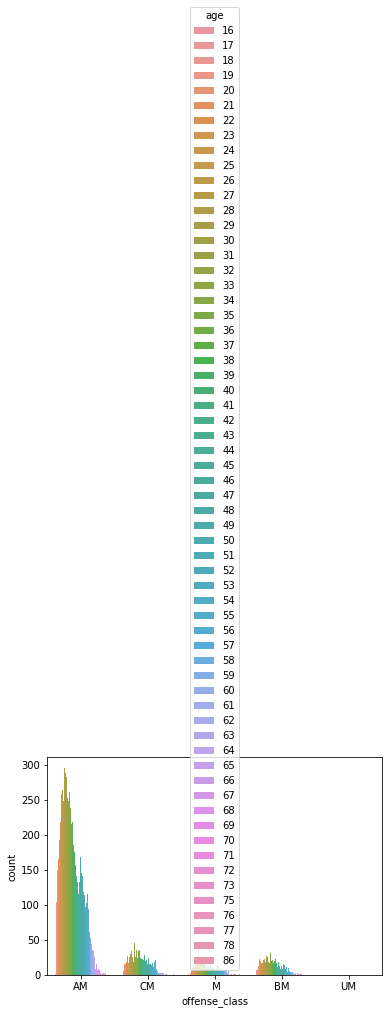

In [28]:
sns.countplot(x='offense_class', hue='age', data=misdemeanor_df)

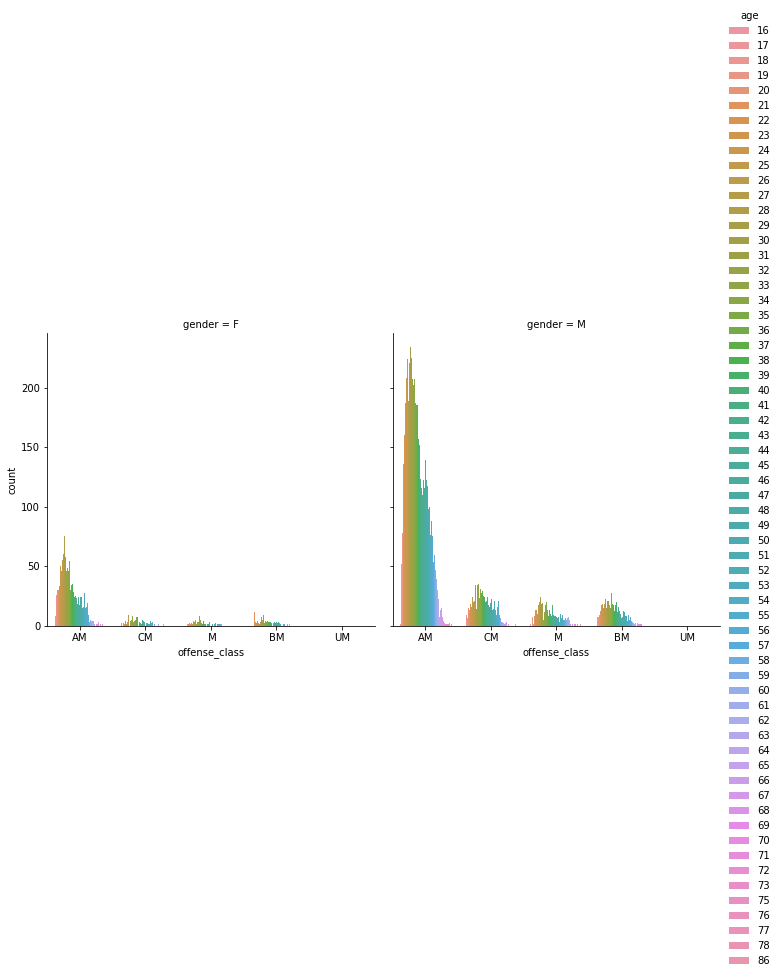

In [29]:
sns.catplot(x="offense_class", hue="age", col="gender", data=misdemeanor_df, kind="count");

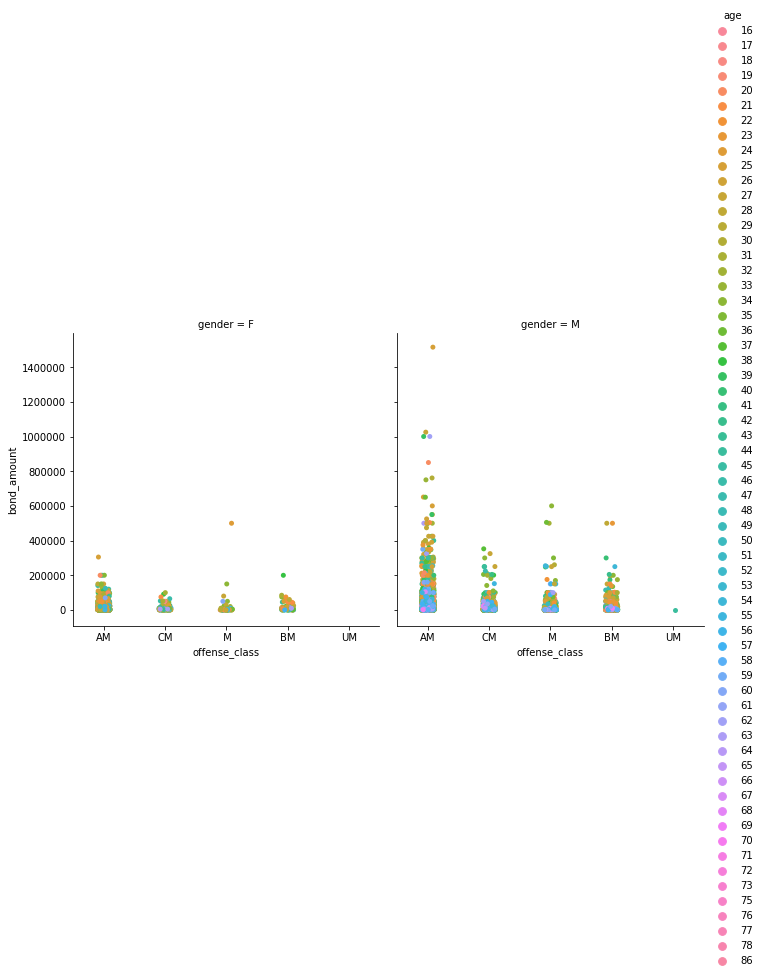

In [30]:
sns.catplot(x="offense_class", hue="age", col="gender", data=misdemeanor_df, y='bond_amount');